I've processed the HDB resale dataset through several key steps to prepare it for analysis:

**Loaded the Dataset**: Imported the resale flat prices data to understand its structure.

**Checked for Missing Value**: Ensured there were no missing values across all columns.

**Converted 'month' to Datetime**: Transformed the 'month' column to datetime format for easier time-based analysis.

**Calculated Flat Age at Sale**: Introduced a new column 'flat_age_at_sale' by subtracting the 'lease_commence_date' from the sale year, providing insights into the effect of flat age on resale price.

**Visual Inspection for Outliers**: Used histograms and boxplots to visually inspect 'floor_area_sqm' and 'resale_price' for outliers, identifying potential anomalies.

**Detected Outliers with IQR**: Applied the Interquartile Range method to 'floor_area_sqm' and 'resale_price' to statistically identify outliers, which were kept as they fall within reasonable ranges for the market.

**Calculated Price Per Square Meter**: Created a new column 'price_per_sqm' to standardize price comparisons, rounding to two decimal places.

**Compute Nearest mrt for the flat and calculate the distance to the nearest mrt**

**Exported Cleaned Data**: Saved the enhanced dataset to 'resale_data_cleaned.csv' for shared access and further analysis.



In [1]:
# First, let's load the dataset to understand its structure and identify the cleaning tasks
import pandas as pd
import numpy as np

# Load the dataset
file_path = './Original_data/ResaleFlatPricesBasedonApprovalDate19901999.csv'
df = pd.read_csv(file_path)

df2 = pd.read_csv("./Original_data/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv")
df3 = pd.read_csv("./Original_data/ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv")
df4 = pd.read_csv("./Original_data/ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv")
df5 = pd.read_csv("./Original_data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")
df = pd.concat([df, df2, df3, df4, df5], ignore_index=True)

# Display the first few rows of the dataframe to understand its structure
df.tail()



,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
919532,2024-02,YISHUN,EXECUTIVE,387,YISHUN RING RD,04 TO 06,142.0,Apartment,1988,820000.0,63 years 05 months
919533,2024-02,YISHUN,EXECUTIVE,355,YISHUN RING RD,01 TO 03,154.0,Maisonette,1988,850000.0,63 years 10 months
919534,2024-02,YISHUN,EXECUTIVE,606,YISHUN ST 61,10 TO 12,142.0,Apartment,1987,795000.0,62 years 11 months
919535,2024-02,YISHUN,EXECUTIVE,824,YISHUN ST 81,07 TO 09,146.0,Maisonette,1987,935000.0,62 years 10 months
919536,2024-02,YISHUN,MULTI-GENERATION,666,YISHUN AVE 4,04 TO 06,164.0,Multi Generation,1987,998000.0,62 years 11 months


In [2]:
# Number of data 
print(len(df))

919537


In [3]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Display the number of missing values in each column
print(missing_values)

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
dtype: int64


In [4]:
# Drop duplicates
df = df.drop_duplicates()
print(len(df))

917643


In [5]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'month' is the column you want to convert
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')

In [6]:
df['year'] = df['month'].dt.year
df['remaining_lease'] = (99 + df['lease_commence_date']) - df['year']


In [7]:
# Calculating the age of the flat at the time of sale
# The age of the flat can be calculated by subtracting the 'lease_commence_date' from the year of the 'month' (sale date)

df['sale_year'] = df['month'].dt.year
df['flat_age_at_sale'] = df['sale_year'] - df['lease_commence_date']

# Dropping the 'sale_year' column as it was only used for calculation
df.drop('sale_year', axis=1, inplace=True)

# Display the first few rows to confirm the addition of 'flat_age_at_sale'
df[['month', 'town', 'flat_type', 'lease_commence_date', 'flat_age_at_sale', 'resale_price']].head()

,month,town,flat_type,lease_commence_date,flat_age_at_sale,resale_price
0,1990-01-01,ANG MO KIO,1 ROOM,1977,13,9000.0
1,1990-01-01,ANG MO KIO,1 ROOM,1977,13,6000.0
2,1990-01-01,ANG MO KIO,1 ROOM,1977,13,8000.0
3,1990-01-01,ANG MO KIO,1 ROOM,1977,13,6000.0
4,1990-01-01,ANG MO KIO,3 ROOM,1976,14,47200.0


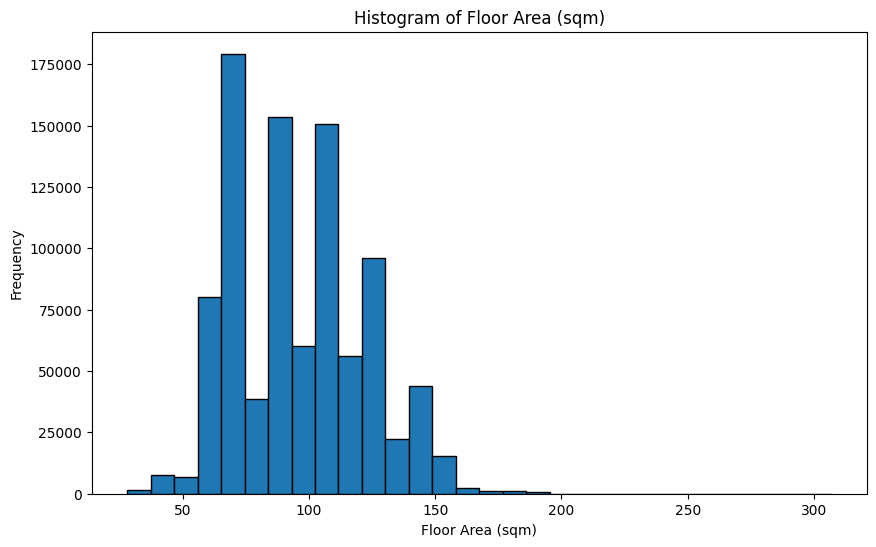

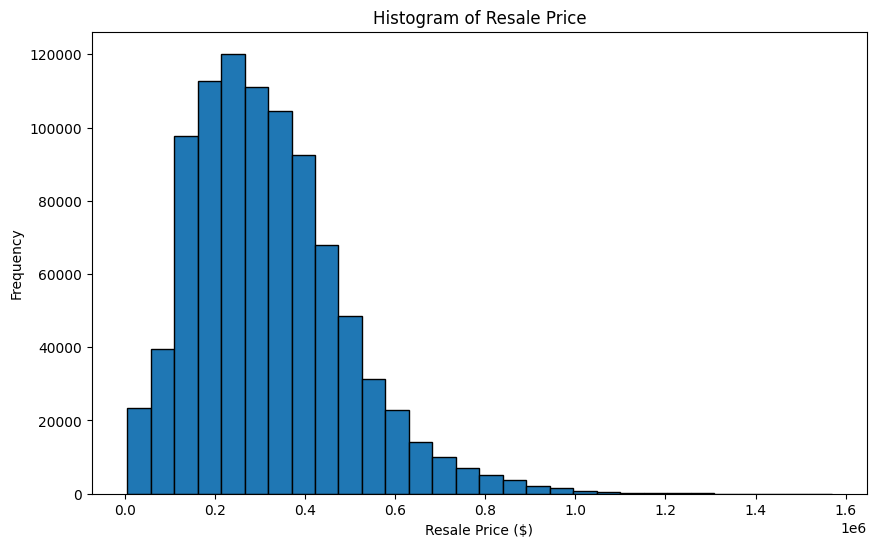

In [8]:
import matplotlib.pyplot as plt

# Plot histogram for 'floor_area_sqm'
plt.figure(figsize=(10, 6))
plt.hist(df['floor_area_sqm'], bins=30, edgecolor='k')
plt.title('Histogram of Floor Area (sqm)')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'resale_price'
plt.figure(figsize=(10, 6))
plt.hist(df['resale_price'], bins=30, edgecolor='k')
plt.title('Histogram of Resale Price')
plt.xlabel('Resale Price ($)')
plt.ylabel('Frequency')
plt.show()


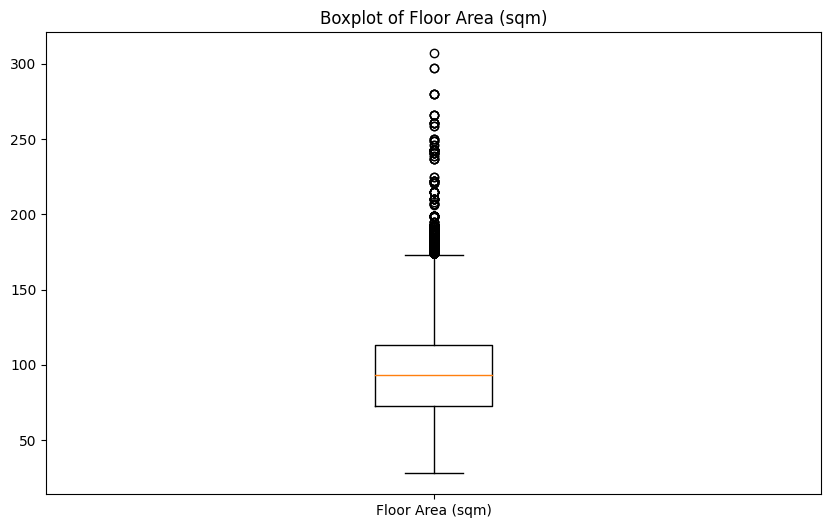

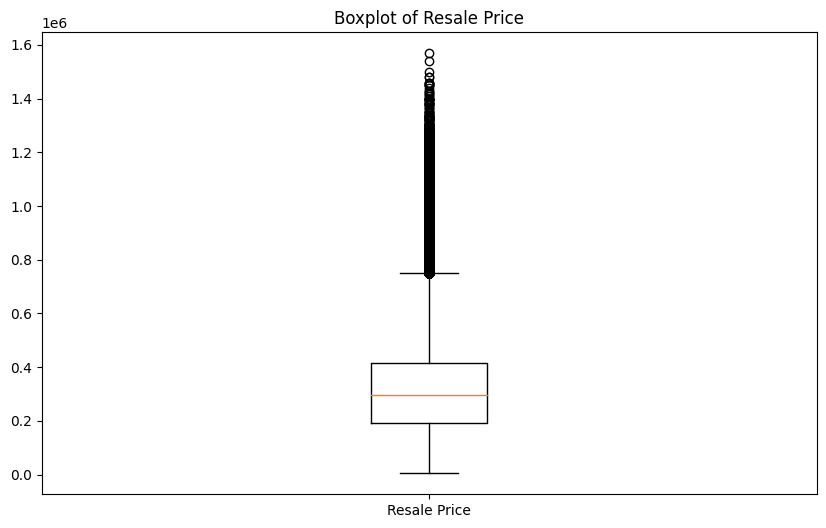

In [9]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['floor_area_sqm'])
plt.title('Boxplot of Floor Area (sqm)')
plt.xticks([1], ['Floor Area (sqm)'])
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(df['resale_price'])
plt.title('Boxplot of Resale Price')
plt.xticks([1], ['Resale Price'])
plt.show()


In [10]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return data[(data < lower_bound) | (data > upper_bound)]

# Detect outliers in 'floor_area_sqm'
outliers_floor_area = detect_outliers_iqr(df['floor_area_sqm'])
print("Outliers in Floor Area (sqm):", outliers_floor_area)

# Detect outliers in 'resale_price'
outliers_resale_price = detect_outliers_iqr(df['resale_price'])
print("Outliers in Resale Price:", outliers_resale_price)

# Howerver even though these data looks like outlier to computer they still falls in a reasonable range in reality.

Outliers in Floor Area (sqm): 3203      206.0
11125     210.0
16992     174.0
28257     198.0
29332     199.0
          ...  
917791    176.0
917792    176.0
918735    208.0
919441    176.0
919529    181.0
Name: floor_area_sqm, Length: 2391, dtype: float64
Outliers in Resale Price: 115438    770000.0
117909    750000.0
125066    780000.0
128456    883000.0
132229    870000.0
            ...   
919532    820000.0
919533    850000.0
919534    795000.0
919535    935000.0
919536    998000.0
Name: resale_price, Length: 18879, dtype: float64


In [11]:
# calculate price per square meter
df['price_per_sqm'] = df['resale_price']/df['floor_area_sqm']
# Round to 2 digits after the decimal point
df['price_per_sqm'] = df['price_per_sqm'].round(2)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year,flat_age_at_sale,price_per_sqm
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,86,1990,13,290.32
1,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,86,1990,13,193.55
2,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,86,1990,13,258.06
3,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,86,1990,13,193.55
4,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,85,1990,14,646.58


In [12]:
# load data
hdb_locations = pd.read_csv("./Original_data/sg_zipcode_mapper_utf.csv")
hdb_locations.head()

,Unnamed: 0,postal,lat,lng,searchval,block,street_name,building,address,postal.1
0,0,398614,1.312763,103.883519,# 1 LOFT,1,LOR 24 GEYLANG,# 1 LOFT,1 LOR 24 GEYLANG # 1 LOFT SINGAPORE 398614,398614
1,1,398721,1.312390,103.881504,# 1 SUITES,1,LOR 20 GEYLANG,# 1 SUITES,1 LOR 20 GEYLANG # 1 SUITES SINGAPORE 398721,398721
2,2,629875,1.309135,103.679463,1 BENOI RD SINGAPORE 629875,1,BENOI RD,NIL,1 BENOI RD SINGAPORE 629875,629875
3,3,439731,1.305466,103.895674,1 BOSCOMBE RD SINGAPORE 439731,1,BOSCOMBE RD,NIL,1 BOSCOMBE RD SINGAPORE 439731,439731
4,4,659592,1.344619,103.749789,1 BT BATOK ST 22 SINGAPORE 659592,1,BT BATOK ST 22,NIL,1 BT BATOK ST 22 SINGAPORE 659592,659592


In [13]:
# remove duplicate in hdb_loactions
hdb_locations = hdb_locations.drop_duplicates(subset=['block', 'street_name'])
# Merge the two dataset
df = pd.merge(df, hdb_locations, how='left', on=['block', 'street_name'])

# Drop records with NaN values
df = df.dropna()

print("Number of records in imputed_dataset after dropping na values:", len(df))
df.head()

Number of records in imputed_dataset after dropping na values: 880310


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,flat_age_at_sale,price_per_sqm,Unnamed: 0,postal,lat,lng,searchval,building,address,postal.1
4,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,...,14,646.58,4428.0,560216.0,1.366197,103.841505,ANG MO KIO 22,ANG MO KIO 22,216 ANG MO KIO AVE 1 ANG MO KIO 22 SINGAPORE 5...,560216.0
5,1990-01-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0,...,13,686.57,9362.0,560211.0,1.369197,103.841667,HDB-ANG MO KIO,HDB-ANG MO KIO,211 ANG MO KIO AVE 3 HDB-ANG MO KIO SINGAPORE ...,560211.0
6,1990-01-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,07 TO 09,67.0,NEW GENERATION,1977,42000.0,...,13,626.87,4464.0,560202.0,1.368446,103.844516,ANG MO KIO VIEW,ANG MO KIO VIEW,202 ANG MO KIO AVE 3 ANG MO KIO VIEW SINGAPORE...,560202.0
7,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10 TO 12,67.0,NEW GENERATION,1977,38000.0,...,13,567.16,15340.0,560235.0,1.366824,103.836491,KEBUN BARU PALM VIEW,KEBUN BARU PALM VIEW,235 ANG MO KIO AVE 3 KEBUN BARU PALM VIEW SING...,560235.0
8,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,04 TO 06,67.0,NEW GENERATION,1977,40000.0,...,13,597.01,15340.0,560235.0,1.366824,103.836491,KEBUN BARU PALM VIEW,KEBUN BARU PALM VIEW,235 ANG MO KIO AVE 3 KEBUN BARU PALM VIEW SING...,560235.0


In [14]:
mrt_locations = pd.read_csv("./Original_data/mrt_data.csv")
mrt_locations.drop(columns=['type'], inplace=True)
mrt_locations.head()

,station_name,lat,lng
0,Jurong East,1.333207,103.742308
1,Bukit Batok,1.349069,103.749596
2,Bukit Gombak,1.359043,103.751863
3,Choa Chu Kang,1.385417,103.744316
4,Yew Tee,1.397383,103.747523


In [15]:
from math import sin, cos, sqrt, atan2, radians
from sklearn.neighbors import KNeighborsClassifier

def earth_distance(x, y):

  # Approximate radius of earth in km
  R = 6373.0

  lat1, lng1 = radians(x[0]), radians(x[1])
  lat2, lng2 = radians(y[0]), radians(y[1])

  dlon = lng2 - lng1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  return R * c

def euclidean_distance(x, y):
  dx = x[0] - y[0]
  dy = x[1] - y[1]

  return sqrt(dx**2 + dy**2)

# Convert latitude and longitude columns to numpy array
X_train = mrt_locations[['lat', 'lng']].values
y_train = mrt_locations['station_name'].values
# Train KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
# Function to find nearest MRT station and calculate distance
def nearest_mrt_distance(x):
    nearest_station = knn.predict(np.array([x]))[0]
    station_location = mrt_locations[mrt_locations['station_name'] == nearest_station][['lat', 'lng']].values[0]
    distance = earth_distance(x, station_location)
    return nearest_station, distance
    
df[['nearest_mrt', 'mrt_dist']] = df.apply(lambda row: pd.Series(nearest_mrt_distance([row['lat'], row['lng']])), axis=1)

df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,Unnamed: 0,postal,lat,lng,searchval,building,address,postal.1,nearest_mrt,mrt_dist
4,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,...,4428.0,560216.0,1.366197,103.841505,ANG MO KIO 22,ANG MO KIO 22,216 ANG MO KIO AVE 1 ANG MO KIO 22 SINGAPORE 5...,560216.0,Ang Mo Kio,0.994577
5,1990-01-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0,...,9362.0,560211.0,1.369197,103.841667,HDB-ANG MO KIO,HDB-ANG MO KIO,211 ANG MO KIO AVE 3 HDB-ANG MO KIO SINGAPORE ...,560211.0,Ang Mo Kio,0.885646
6,1990-01-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,07 TO 09,67.0,NEW GENERATION,1977,42000.0,...,4464.0,560202.0,1.368446,103.844516,ANG MO KIO VIEW,ANG MO KIO VIEW,202 ANG MO KIO AVE 3 ANG MO KIO VIEW SINGAPORE...,560202.0,Ang Mo Kio,0.590664
7,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10 TO 12,67.0,NEW GENERATION,1977,38000.0,...,15340.0,560235.0,1.366824,103.836491,KEBUN BARU PALM VIEW,KEBUN BARU PALM VIEW,235 ANG MO KIO AVE 3 KEBUN BARU PALM VIEW SING...,560235.0,Ang Mo Kio,1.499241
8,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,04 TO 06,67.0,NEW GENERATION,1977,40000.0,...,15340.0,560235.0,1.366824,103.836491,KEBUN BARU PALM VIEW,KEBUN BARU PALM VIEW,235 ANG MO KIO AVE 3 KEBUN BARU PALM VIEW SING...,560235.0,Ang Mo Kio,1.499241


In [16]:
# Drop those columns that are not useful
columns_to_drop = ['Unnamed: 0', 'postal.1', 'lat', 'lng', 'searchval', 'building', 'address']
df = df.drop(columns=columns_to_drop)

In [17]:
# Export the DataFrame to a CSV file
df.to_csv('./Cleaned_data/resale_data_cleaned.csv', index=False)

In [18]:
print(len(df))

880310
